Note: you may need to restart the kernel to use updated packages.
Protocols present in your data: ['eSISPA' 'PtCl4 eSISPA' 'Standard SISPA']


/Users/jeanclaudemakangara/venvs/panzi_env/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


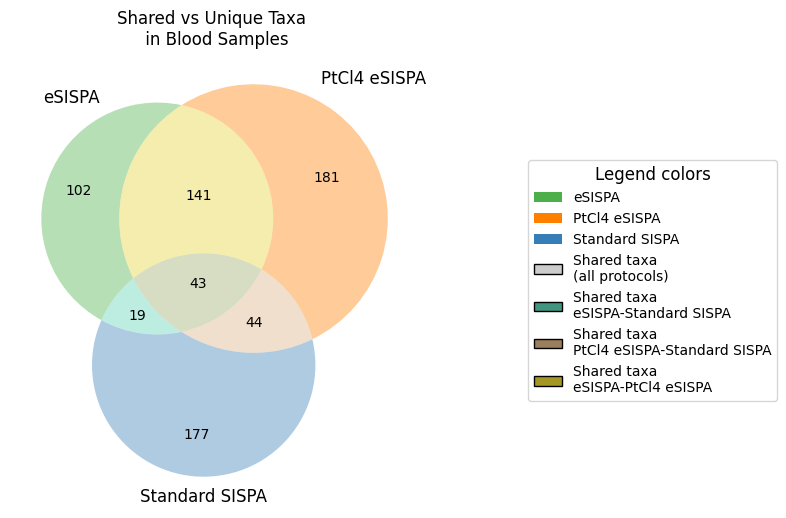

In [3]:
%pip install pandas numpy seaborn matplotlib upsetplot --quiet

import sys
!{sys.executable} -m pip install upsetplot
!pip install seaborn matplotlib-venn

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from upsetplot import from_memberships, plot as upset_plot
from matplotlib.patches import Patch

outputdir = "/Users/jeanclaudemakangara/Library/CloudStorage/OneDrive-UniversitaetBern/ISPM_PhD_Project_Makangara_Cigolo_Jean_Claude/Writing_manuscript/Protocol_comparison_Panzi/protocol_comparison_Panzi_manuscript_Python_script/outputs"
os.makedirs(outputdir, exist_ok=True)

# BLOOD SAMPLES: RAW DATA DISTRIBUTION AND VENN PLOT

# Load data
df = pd.read_csv("/Users/jeanclaudemakangara/Library/CloudStorage/OneDrive-UniversitaetBern/ISPM_PhD_Project_Makangara_Cigolo_Jean_Claude/Writing_manuscript/Protocol_comparison_Panzi/protocol_comparison_Panzi_manuscript_Python_script/data/fig_6_7_8_z_blood_samples.csv")

selected_names = ["virus", "bacteria", "eukaryota", "archaea"]
protocol_order = ['eSISPA', 'PtCl4 eSISPA', 'Standard SISPA']

# Clean column names and protocol names
df.columns = [col.strip().lower() for col in df.columns]
df['protocol'] = df['protocol'].str.strip()

# filter samples with z-score > 1
df = df[df['category'].isin(selected_names)]
df = df[np.log10(df['z_score'] + 1) > 0.29]

# Print protocols present
print("Protocols present in your data:", df['protocol'].unique())

# Summary Table 1: Number of taxa detected per protocol
num_taxa = df.groupby('protocol')['name'].nunique().reset_index(name='num_taxa')

# Summary Table 2: Total nt_count and nr_count per protocol
nt_nr_sum = df.groupby('protocol')[['nt_count', 'nr_count']].sum().reset_index()

# Top 20 taxa by nt_count per protocol
top20 = df.sort_values(['protocol', 'nt_count'], ascending=[True, False])\
          .groupby('protocol').head(20)

# Shared vs unique taxa (using ALL taxa, not just top 20)
protocol_taxa = {p: set(df[df['protocol'] == p]['name']) for p in df['protocol'].unique()}
protocol_list = list(protocol_taxa.keys())
while len(protocol_list) < 3:
    protocol_list.append(f"dummy_{len(protocol_list)+1}")
    protocol_taxa[protocol_list[-1]] = set()  # Add empty set for missing protocol

sets = [protocol_taxa[p] for p in protocol_list]
shared_taxa = set.intersection(*[s for s in sets if len(s) > 0])
unique_taxa = {p: protocol_taxa[p] - shared_taxa for p in protocol_list}

# Log2 Fold-change for shared taxa
shared_df = df[df['name'].isin(shared_taxa)]
agg_df = shared_df.groupby(['name', 'protocol'], as_index=False)['nt_count'].sum()
pivot_nt = agg_df.pivot(index='name', columns='protocol', values='nt_count').fillna(0)
logfc = pivot_nt.apply(lambda x: np.log2((x + 1) / (x.mean() + 1)), axis=1)

# Visualization 2: Venn3 diagram for 3 protocols (with dummy if needed)
venn3_subsets = (
    len(sets[0] - sets[1] - sets[2]),
    len(sets[1] - sets[0] - sets[2]),
    len(sets[0] & sets[1] - sets[2]),
    len(sets[2] - sets[0] - sets[1]),
    len(sets[0] & sets[2] - sets[1]),
    len(sets[1] & sets[2] - sets[0]),
    len(sets[0] & sets[1] & sets[2])
)

protocol_color_map = {
    "eSISPA": "#4daf4a",           # green
    "PtCl4 eSISPA": "#ff7f00",     # orange
    "Standard SISPA": "#377eb8"    # blue
}
while len(protocol_list) < 3:
    protocol_list.append(f"dummy_{len(protocol_list)+1}")
    protocol_color_map[protocol_list[-1]] = "#bdbdbd"  # gray for dummy

venn_colors = [protocol_color_map[p] for p in protocol_list]


# After plotting the Venn diagram, extract and save shared taxa to CSV
shared_taxa = set.intersection(*[s for s in sets if len(s) > 0])

# Save shared taxa as a CSV file
shared_taxa_df = pd.DataFrame({"shared_taxa": sorted(shared_taxa)})
shared_taxa_df.to_csv(os.path.join(outputdir, "shared_taxa_blood_samples.csv"), index=False)


plt.figure(figsize=(8, 8))
venn3(subsets=venn3_subsets, set_labels=protocol_list, set_colors=venn_colors)

handles = [
    Patch(facecolor=protocol_color_map["eSISPA"], label="eSISPA"),
    Patch(facecolor=protocol_color_map["PtCl4 eSISPA"], label="PtCl4 eSISPA"),
    Patch(facecolor=protocol_color_map["Standard SISPA"], label="Standard SISPA"),
    Patch(facecolor="#cccccc", edgecolor='black', label="Shared taxa \n(all protocols)"),
    Patch(facecolor="#429681", edgecolor='black', label="Shared taxa \neSISPA-Standard SISPA"),
    Patch(facecolor="#9b7e5c", edgecolor='black', label="Shared taxa \nPtCl4 eSISPA-Standard SISPA"),
    Patch(facecolor="#a69725", edgecolor='black', label="Shared taxa \neSISPA-PtCl4 eSISPA")
]

plt.title("Shared vs Unique Taxa \n in Blood Samples")
plt.legend(
    handles=handles, 
    title="Legend colors", 
    loc='center left', 
    bbox_to_anchor=(1.25, 0.5),
    fontsize='medium',
    title_fontsize='large',)
plt.tight_layout()
plt.savefig(os.path.join(outputdir, "fig_7a_venn_taxa_blood_samples.png"), bbox_inches='tight')
plt.show()
plt.close()

# Export summary tables
num_taxa.to_csv(os.path.join(outputdir, "summary_num_taxa_blood_raw.csv"), index=False)
nt_nr_sum.to_csv(os.path.join(outputdir, "summary_nt_nr_blood_raw.csv"), index=False)
top20.to_csv(os.path.join(outputdir, "top20_taxa_per_blood_raw.csv"), index=False)
logfc.to_csv(os.path.join(outputdir, "log2fc_shared__blood_raw.csv"))

/Users/jeanclaudemakangara/venvs/panzi_env/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


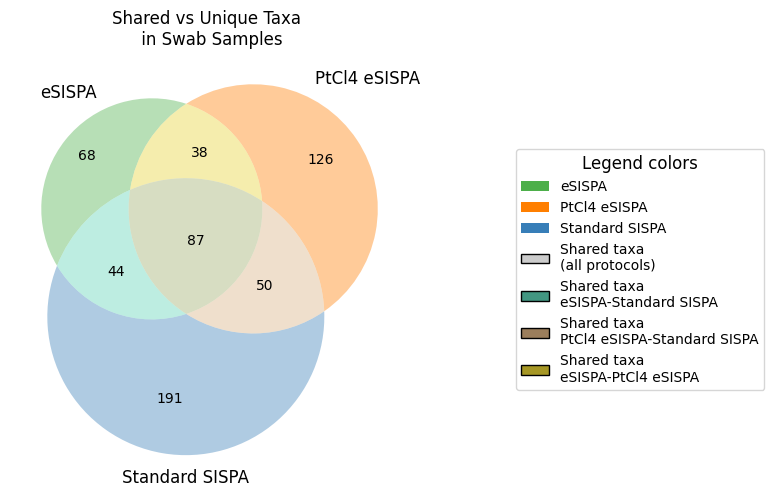

In [2]:
import sys
!{sys.executable} -m pip install upsetplot
!pip install seaborn matplotlib-venn

import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from matplotlib.patches import Patch

outputdir = "/Users/jeanclaudemakangara/Library/CloudStorage/OneDrive-UniversitaetBern/ISPM_PhD_Project_Makangara_Cigolo_Jean_Claude/Writing_manuscript/Protocol_comparison_Panzi/protocol_comparison_Panzi_manuscript_Python_script/outputs"
os.makedirs(outputdir, exist_ok=True)

# SWAB SAMPLES: VENN DIAGRAM ONLY

df = pd.read_csv("/Users/jeanclaudemakangara/Library/CloudStorage/OneDrive-UniversitaetBern/ISPM_PhD_Project_Makangara_Cigolo_Jean_Claude/Writing_manuscript/Protocol_comparison_Panzi/protocol_comparison_Panzi_manuscript_Python_script/data/fig_6_7_z_swab_samples.csv")
selected_names = ["virus", "bacteria", "eukaryota", "archaea"]

# Clean column names and protocol names
df.columns = [col.strip().lower() for col in df.columns]
df['protocol'] = df['protocol'].str.strip()

# Filter samples with z-score > 1 and selected categories
df = df[df['category'].isin(selected_names)]
df = df[np.log10(df['z_score'] + 1) > 0.29]

# Prepare protocol taxa sets
protocol_taxa = {p: set(df[df['protocol'] == p]['name']) for p in df['protocol'].unique()}
protocol_list = list(protocol_taxa.keys())
while len(protocol_list) < 3:
    dummy_name = f"dummy_{len(protocol_list)+1}"
    protocol_list.append(dummy_name)
    protocol_taxa[dummy_name] = set()
    # Add color for dummy protocol
    protocol_color_map = {
        "eSISPA": "#4daf4a",
        "PtCl4 eSISPA": "#ff7f00",
        "Standard SISPA": "#377eb8"
    }
    protocol_color_map[dummy_name] = "#bdbdbd"
else:
    protocol_color_map = {
        "eSISPA": "#4daf4a",
        "PtCl4 eSISPA": "#ff7f00",
        "Standard SISPA": "#377eb8"
    }
    for p in protocol_list:
        if p not in protocol_color_map:
            protocol_color_map[p] = "#bdbdbd"

sets = [protocol_taxa[p] for p in protocol_list]
venn3_subsets = (
    len(sets[0] - sets[1] - sets[2]),
    len(sets[1] - sets[0] - sets[2]),
    len(sets[0] & sets[1] - sets[2]),
    len(sets[2] - sets[0] - sets[1]),
    len(sets[0] & sets[2] - sets[1]),
    len(sets[1] & sets[2] - sets[0]),
    len(sets[0] & sets[1] & sets[2])
)

venn_colors = [protocol_color_map[p] for p in protocol_list]

# After plotting the Venn diagram, extract and save shared taxa to CSV
shared_taxa = set.intersection(*[s for s in sets if len(s) > 0])

# Save shared taxa as a CSV file
shared_taxa_df = pd.DataFrame({"shared_taxa": sorted(shared_taxa)})
shared_taxa_df.to_csv(os.path.join(outputdir, "shared_taxa_swab_samples.csv"), index=False)

plt.figure(figsize=(8, 8))
venn3(subsets=venn3_subsets, set_labels=protocol_list, set_colors=venn_colors)

handles = [
    Patch(facecolor=protocol_color_map.get("eSISPA", "#bdbdbd"), label="eSISPA"),
    Patch(facecolor=protocol_color_map.get("PtCl4 eSISPA", "#bdbdbd"), label="PtCl4 eSISPA"),
    Patch(facecolor=protocol_color_map.get("Standard SISPA", "#bdbdbd"), label="Standard SISPA"),
    Patch(facecolor="#cccccc", edgecolor='black', label="Shared taxa \n(all protocols)"),
    Patch(facecolor="#429681", edgecolor='black', label="Shared taxa \neSISPA-Standard SISPA"),
    Patch(facecolor="#9b7e5c", edgecolor='black', label="Shared taxa \nPtCl4 eSISPA-Standard SISPA"),
    Patch(facecolor="#a69725", edgecolor='black', label="Shared taxa \neSISPA-PtCl4 eSISPA")
]

plt.title("Shared vs Unique Taxa \n in Swab Samples")
plt.legend(
    handles=handles, 
    title="Legend colors", 
    loc='center left', 
    bbox_to_anchor=(1.25, 0.5),
    fontsize='medium',
    title_fontsize='large',)
plt.tight_layout()
plt.savefig(os.path.join(outputdir, "fig_7b_venn_taxa_swab_sample.png"), bbox_inches='tight')
plt.show()
plt.close()